# Optics Design for High Time Resolution Measurements with TDS

This tutorial is motivated by a practical task: improving the time resolution of current profile measurements using a Transverse Deflecting Structure (TDS) at the European XFEL (EuXFEL).

---

## A Bit of Simple Theory

The transverse position of a particle along a beamline is given by:

$$
x(s) = A \sqrt{\beta_x(s)} \cos(\Phi_x(s) + \Phi_0)
$$

where:

- $\beta_x(s)$ is the betatron function at position $s$,
- $\Phi_x(s) = \int_{s_0}^{s} \frac{1}{\beta_x(s)} \, ds$ is the betatron phase,
- $\Phi'_x(s) = \frac{1}{\beta_x(s)}$.

Taking the derivative:

$$
x'(s) = -\frac{A}{\sqrt{\beta_x(s)}} \left[ \alpha_x(s) \cos(\Phi_x(s) + \Phi_0) + \sin(\Phi_x(s) + \Phi_0) \right],
$$

with $\alpha_x(s) = -\frac{1}{2} \beta_x'(s)$.

---

### At the TDS Position

Let’s assume the TDS is located at $s = 0$:

- The particle receives a transverse kick: $x'_{\text{tds}} = x'(0)$,
- The transverse position at the TDS is zero: $x(0) = 0$.

Then:

$$
0 = A \sqrt{\beta_x(0)} \cos(\Phi_0) \Rightarrow \Phi_0 = \frac{\pi}{2}
$$

From this, we get:

$$
x'_{\text{tds}} = -\frac{A}{\sqrt{\beta_x(0)}} \Rightarrow A = -x'_{\text{tds}} \sqrt{\beta_x(0)}
$$

---

### At the Screen

The transverse position on the screen becomes:

$$
x(s) = A \sqrt{\beta_x(s)} \cos(\Delta\Phi_x + \Phi_0)
$$

With $\Phi_0 = \frac{\pi}{2}$ and using the identity $\cos(\psi + \pi/2) = -\sin(\psi)$:

$$
x_{\text{scr}} = x'_{\text{tds}} \sqrt{\beta_x(s_{\text{tds}}) \beta_x(s_{\text{scr}})} \sin(\Delta\Phi_x)
$$

---

## Transverse Kick from the Deflecting Structure

The kick from the TDS depends on time:

$$
\Delta x'_{\text{tds}}(t) = \frac{e V_0}{p c} \sin\left( \frac{2\pi c t}{\lambda} + \varphi \right) 
\approx \frac{e V_0}{p c} \left( \frac{2\pi c t}{\lambda} \cos \varphi + \sin \varphi \right)
$$

Assuming $\varphi = 0$ (zero-crossing), the rms beam size on the screen is:

$$
\sigma_x^{\text{scr}} = \frac{e V_0}{p c} \cdot \frac{2\pi c \sigma_t}{\lambda} \cdot \sqrt{\beta_x(s_{\text{tds}}) \beta_x(s_{\text{scr}})} \cdot \sin(\Delta\Phi_x)
$$

---

## Time Resolution of the TDS

### Streaking (Calibration) Factor

The streaking factor is:

$$
S = \frac{\sigma_x^{\text{scr}}}{c \sigma_t} = \frac{e V_0}{p c} \cdot \frac{2\pi}{\lambda} \cdot \sqrt{\beta_x(s_{\text{tds}}) \beta_x(s_{\text{scr}})} \cdot \sin(\Delta\Phi_x)
$$

### Time Resolution

The time resolution is defined as:

$$
R_t = \frac{\sigma_{x0}^{\text{scr}}}{c S}
$$

Using $\sigma_{x0}^{\text{scr}} = \sqrt{\varepsilon_x \beta_x(s_{\text{scr}})}$, we get:

$$
R_t = \frac{\sqrt{\varepsilon_x}}{\frac{e V_0}{p} \cdot \frac{2\pi}{\lambda} \cdot \sqrt{\beta_x(s_{\text{tds}})} \cdot \sin(\Delta\Phi_x)}
$$

So the **time resolution depends only on**:

- emittance $\varepsilon_x$
- voltage $V_0$
- wavelength $\lambda$
- beta function at the TDS
- phase advance between TDS and screen

## Practical Example: Optimizing Time Resolution with TDS at EuXFEL

In this section, we apply the theory from the previous part to a real EuXFEL lattice using Ocelot.

In [1]:
import sys 
sys.path.append("/Users/tomins/Nextcloud/DESY/repository/ocelot/")
import os
import copy
import pandas as pd

from ocelot import *
from ocelot.gui import *
import l2, l3 # lattices can be found in https://github.com/ocelot-collab/EuXFEL-Lattice/tree/main/lattices/longlist_2024_07_04


initializing ocelot...


## Check design optics 

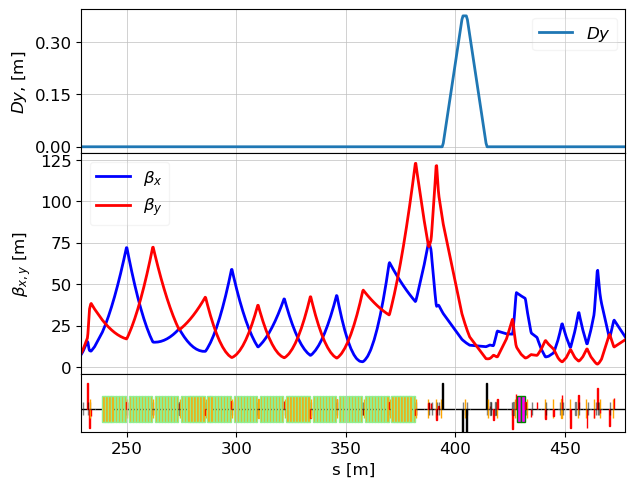

In [2]:
lat_l2 = MagneticLattice(l2.cell + l3.cell, stop=l3.id_32072837_) # id_32072837_ - Drift in front of first A6 RF module
tws = twiss(lat_l2, tws0=l2.tws0)
plot_opt_func(lat_l2, tws, top_plot=["Dy"], legend=False)
plt.savefig("L2_design.png") 
plt.show()


## Check Twiss Parameters at Key Elements

We use markers for the TDS and screens (e.g., `marker_tds_b2`, `otrb_457_b2`) and inspect relevant optics values like beta functions and phase advances.

In [3]:
tws = twiss(lat_l2, tws0=l2.tws0, attach2elem=True)
# with attach2elem=True to all elements will be attached Twiss object in element.tws
# let's print beta_x
print(l2.ensub_466_b2.tws.beta_y)

4.9841234890954


## Define Matching Start and End Points

We preserve Twiss parameters at `match_385_b2` (entry point after L2) and `id_32072837_` (end of lattice).

In [4]:
tws_match_385 = copy.deepcopy(l2.match_385_b2.tws)
tws_end = copy.deepcopy(l3.id_32072837_.tws)

## Shorten Lattice to Relevant Region

We exclude upstream quadrupoles and start optimization just after L2.

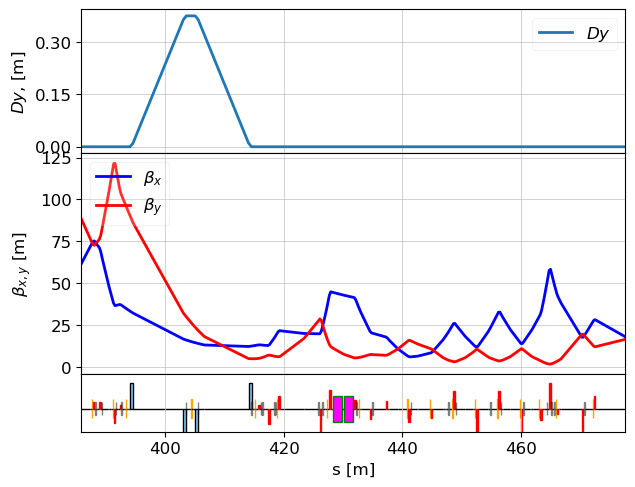

In [5]:
lat = MagneticLattice(l2.cell+l3.cell, start=l2.match_385_b2, stop=l3.id_32072837_)
tws_des = twiss(lat, tws0=tws_match_385)
plot_opt_func(lat, tws_des, top_plot = ["Dy"], legend=False)
plt.savefig("TDS_area_design.png")
plt.show()

#### (Optional) Save Quadrupole Strengths for Reference

We optionally store the design quadrupole strengths in a CSV file for comparison later. The function looks a bit complicated just because I wanted to avoid overwriting every time design quads strengths.

In [6]:
# let's save design kicks to a dictionary
df_filename = "quads_strengths.csv"
design_column = "design"
if os.path.exists(df_filename):
    quads_kicks_df = pd.read_csv(df_filename, index_col=0)
    if design_column in quads_kicks_df.columns:
        print(f"Column '{design_column}' already exists. Skipping step.")
    else:
        print(f"Column '{design_column}' not found. Proceeding to add it.")
        quads_kicks_df[design_column] = pd.Series(d_design)
        df.to_csv(df_filename)
else:
    print("File does not exist. Creating new DataFrame.")
    # let's save design kicks to a dictionary
    d_design = {}
    for e in lat.sequence:
        if e.__class__ == Quadrupole:
            d_design[e.id] = e.k1
    quads_kicks_df = pd.DataFrame({design_column: d_design})
    quads_kicks_df.to_csv(df_filename, index=True) 

Column 'design' already exists. Skipping step.


## Display Twiss Parameters at Specific Elements

We define a helper function to show selected optics values and compute R12 matrix elements.

It can be done in different ways but we will use pandas. 

In [7]:

# List of elements where we want to see Twiss parameters
elements_for_comparision = {'TDS 429': l2.marker_tds_b2, "Scr 450": l2.otrb_450_b2,  "Scr 454": l2.otrb_454_b2, 'Scr 457': l2.otrb_457_b2, 'Scr 461': l2.otrb_461_b2, 'end': l3.id_32072837_}

# Attributes we want to compare
attributes = ['beta_x', 'beta_y', 'alpha_x', 'alpha_y', 'mux', "muy"]

def table_update(lat, tws0, elements_for_comparision, attributes):
    # calculate Twiss
    tws = twiss(lat, tws0=tws0, attach2elem=True)
    
    # Build the table from tws list
    table = pd.DataFrame({name: [getattr(getattr(obj, "tws"), attr) for attr in attributes] for name, obj in elements_for_comparision.items()},
                     index=attributes)
    # make phase advance in degree
    table.loc['mux'] = (table.loc['mux'] - table.loc['mux', 'TDS 429'])*180/np.pi
    table.loc['muy'] = (table.loc['muy'] - table.loc['muy', 'TDS 429'])*180/np.pi
    # add R12 elements into table 
    R12_values = copy.copy(elements_for_comparision)
    for key in R12_values:
        stop_elem = elements_for_comparision[key]
        _, R, _ = lat.transfer_maps(energy=2.4, start=l2.marker_tds_b2, stop=stop_elem)
        R12_values[key] = R[0, 1]
    table.loc['R12'] = R12_values
    return table
table = table_update(lat, tws_match_385, elements_for_comparision, attributes)
table

,TDS 429,Scr 450,Scr 454,Scr 457,Scr 461,end
beta_x,43.053180,18.251948,20.968219,22.373178,23.377576,18.128801
beta_y,7.934085,5.763031,6.196580,6.343081,6.033306,16.635496
alpha_x,0.430495,1.974248,-2.912536,2.635599,-2.959366,0.773439
alpha_y,0.823006,-1.003279,0.967638,-1.012782,1.062611,-0.652910
mux,0.000000,87.585305,102.060092,110.131938,122.478302,156.118641
muy,0.000000,166.603158,193.829980,240.637210,266.863817,406.008475
R12,0.000000,28.007312,29.382633,29.139827,26.763092,11.310323


## Matching

### Objective: High Beta at TDS and 90° Phase Advance to Screen

We now want to modify the optics such that:

- The beta function at the TDS position is large (e.g., 120 m), which improves time resolution.
- The phase advance between the TDS and screen is exactly 90 degrees.

To achieve this, we define a set of constraints and a list of quadrupoles we allow the matcher to modify.

initial value: x =  [0.1844935101732075, -1.1613414142701166, 0.9333180854580516, 0.483128043546324, -0.5546501686345575, 0.4338977464116816, -0.821514494913287, -0.5209682972602552, 0.7717722188952563, -1.7097911499779723, 0.9364025379557392]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 266
         Function evaluations: 516


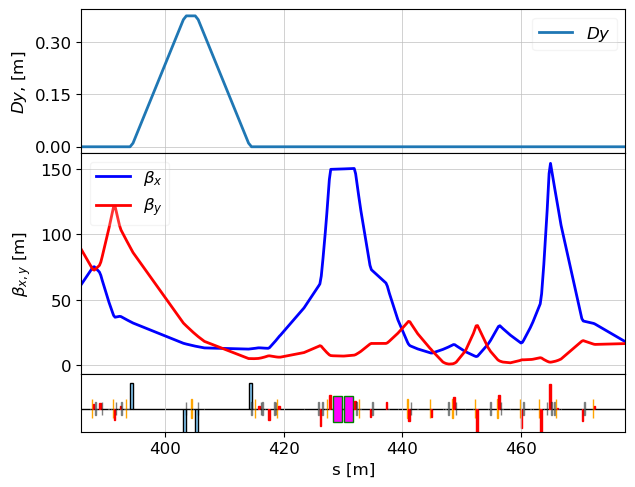

In [16]:
constr = {
    l2.marker_tds_b2: {"beta_x": 150},
    l2.otrb_457_b2: {"beta_x": 23},
    "delta": {
        l2.marker_tds_b2: ["mux", 0],
        l2.otrb_457_b2: ["mux", 0],
        "val": np.pi / 2,
        "weight": 1_000_007
    },
}

vars = [
    #l2.qd_417_b2, 
    l2.qd_418_b2, l2.qd_425_b2, l2.qd_427_b2,
    l2.qd_431_b2, l2.qd_434_b2, l2.qd_437_b2, l2.qd_440_b2,
    l2.qd_444_b2, l2.qd_448_b2, l2.qd_452_b2, l2.qd_456_b2
]

match(lat, constr, vars, tw=tws_match_385, verbose=False, max_iter=1000, method='simplex')
tws = twiss(lat, tws0=tws_match_385)
plot_opt_func(lat, tws, top_plot=["Dy"], legend=False)
plt.show()

In [17]:
table = table_update(lat, tws_match_385, elements_for_comparision, attributes)
table

,TDS 429,Scr 450,Scr 454,Scr 457,Scr 461,end
beta_x,150.000000,10.414000,16.014326,23.000000,33.098801,17.982775
beta_y,7.039881,11.003765,13.715431,1.899892,4.611588,16.561764
alpha_x,-0.082421,1.261657,-3.204890,1.853110,-5.105454,1.025568
alpha_y,-0.056119,-3.933748,3.765855,-0.110422,-0.324276,-0.222728
mux,0.000000,56.836034,80.987302,90.000002,100.208613,123.541285
muy,0.000000,200.248671,211.325180,275.806148,343.264402,464.870140
R12,0.000000,33.085385,48.406606,58.736700,69.346003,43.288574


### Matching to Final Conditions

We now restore the beam optics to match the original design values at the end of the beamline.

initial value: x =  [-1.697299415751249, 1.658228513129535, 0.0500172029505534, -0.8230593470053236, 0.1510492852216488]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 972
         Function evaluations: 1544


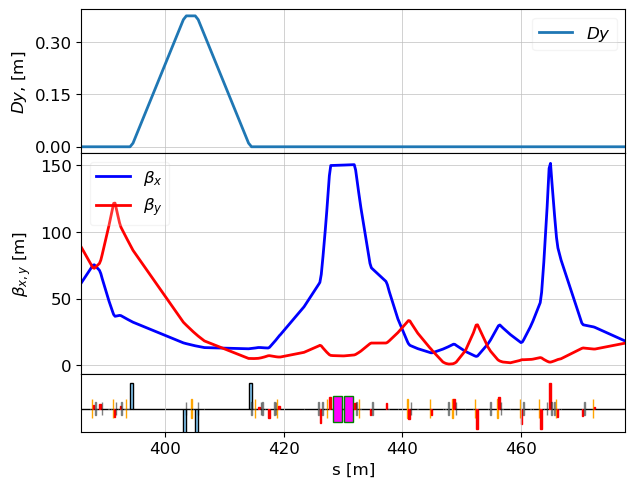

,TDS 429,Scr 450,Scr 454,Scr 457,Scr 461,end
beta_x,150.000000,10.414000,16.014326,23.000000,33.098801,18.128801
beta_y,7.039881,11.003765,13.715431,1.899892,4.611588,16.635495
alpha_x,-0.082421,1.261657,-3.204890,1.853110,-5.105454,0.773441
alpha_y,-0.056119,-3.933748,3.765855,-0.110422,-0.324276,-0.652906
mux,0.000000,56.836034,80.987302,90.000002,100.208613,125.580935
muy,0.000000,200.248671,211.325180,275.806148,343.264402,471.937020
R12,0.000000,33.085385,48.406606,58.736700,69.346003,42.410946


In [18]:
constr_end = {
    l3.id_32072837_: {
        "beta_x": tws_end.beta_x,
        "beta_y": tws_end.beta_y,
        "alpha_x": tws_end.alpha_x,
        "alpha_y": tws_end.alpha_y
    }
}

vars_end = [
    #l2.qd_459_b2, 
    l2.qd_463_b2, l2.qd_464_b2, l2.qd_465_b2,
    l3.qd_470_b2, l3.qd_472_b2
]

match(lat, constr_end, vars_end, tw=tws_match_385, verbose=False, max_iter=2000, method='simplex')
tws_hi_res = twiss(lat, tws0=tws_match_385)
plot_opt_func(lat, tws_hi_res, top_plot=["Dy"], legend=False)
plt.show()
table = table_update(lat, tws_match_385, elements_for_comparision, attributes)
table

## Compare design and new optics

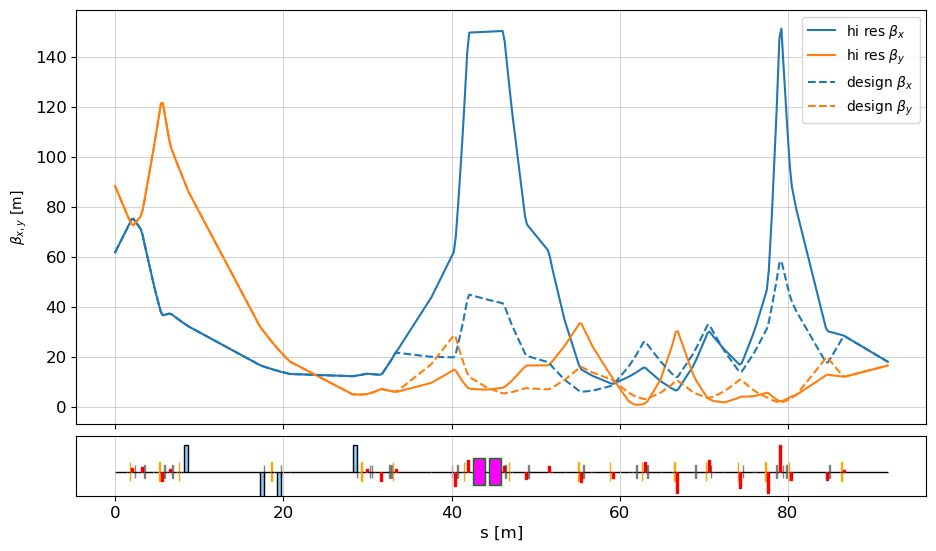

In [19]:
bx_n = [tw.beta_x for tw in tws_hi_res]
by_n = [tw.beta_y for tw in tws_hi_res]
s_n = np.array([tw.s for tw in tws_hi_res])
bx_d = [tw.beta_x for tw in tws_des]
by_d = [tw.beta_y for tw in tws_des]
s_d = np.array([tw.s for tw in tws_des])

fig, ax = plot_API(lat, legend=False, figsize=[10,6])

ax.plot(s_n - s_n[0], bx_n, 'C0', label=r"hi res $\beta_{x}$ ")
ax.plot(s_n - s_n[0], by_n, 'C1', label=r"hi res $\beta_{y}$ ")
ax.plot(s_d - s_d[0], bx_d, "C0--", label=r"design $\beta_{x}$ ")
ax.plot(s_d - s_d[0], by_d, "C1--", label=r"design $\beta_{y}$ ")
ax.set_ylabel(r"$\beta_{x,y}$ [m]")
ax.legend()
#plt.savefig("TDS_90m.png") 
plt.show()

In [20]:
for key in ['beta_x', "beta_y", "alpha_x", "alpha_y"]:
    print(key, " :", getattr(tws_hi_res[-1], key), getattr(tws_des[-1], key))

beta_x  : 18.128800592964286 18.128800557003874
beta_y  : 16.635495296596645 16.63549612797459
alpha_x  : 0.7734407481687121 0.773439275717092
alpha_y  : -0.6529062102144045 -0.6529100059044322


## Write to dataframe new quads kicks. Change name of `new_colimn`

In [25]:
WRITE_TO_FILE = False

beta_tds_ampl = constr[l2.marker_tds_b2]["beta_x"] 
new_column = f'TDS {beta_tds_ampl}m'


quads_kicks_df = pd.read_csv(df_filename, index_col=0)
# let's save design kicks to a dictionary
d_new = {}
for e in lat.sequence:
    if e.__class__ == Quadrupole:
        d_new[e.id] = e.k1
if WRITE_TO_FILE:
    if new_column in quads_kicks_df.columns:
        print(f"Column '{new_column}' already exists. Skipping step.")
    else:
        print(f"Column '{new_column}' not found. Proceeding to add it.")
        quads_kicks_df[new_column] = pd.Series(d_new)
        quads_kicks_df.to_csv(df_filename)

quads_kicks_df

,design,TDS 70m,TDS 90m,TDS 120m,TDS 140m,TDS 150m
QD.387.B2,0.335173,0.335173,0.335173,0.335173,0.335173,0.335173
QD.388.B2,0.355996,0.355996,0.355996,0.355996,0.355996,0.355996
QD.391.B2,-0.725525,-0.725525,-0.725525,-0.725525,-0.725525,-0.725525
QD.392.B2,0.196996,0.196996,0.196996,0.196996,0.196996,0.196996
QD.415.B2,0.180686,0.180686,0.180686,0.180686,0.180686,0.180686
QD.417.B2,-0.750235,-0.786637,-0.750235,-0.750235,-0.750235,-0.750235
QD.418.B2,0.649193,0.551447,0.449237,0.318383,0.273962,0.184787
QD.425.B2,-1.300803,-1.354912,-1.486218,-1.300698,-1.347924,-1.162006
QD.427.B2,0.941484,0.958903,1.061193,0.968098,0.966920,0.933300
QD.431.B2,0.435183,0.456869,0.465343,0.482648,0.506263,0.482781


## Check optics again from dataframe 

In [22]:
quads_kicks_df = pd.read_csv(df_filename, index_col=0)
quads = list(quads_kicks_df.index)

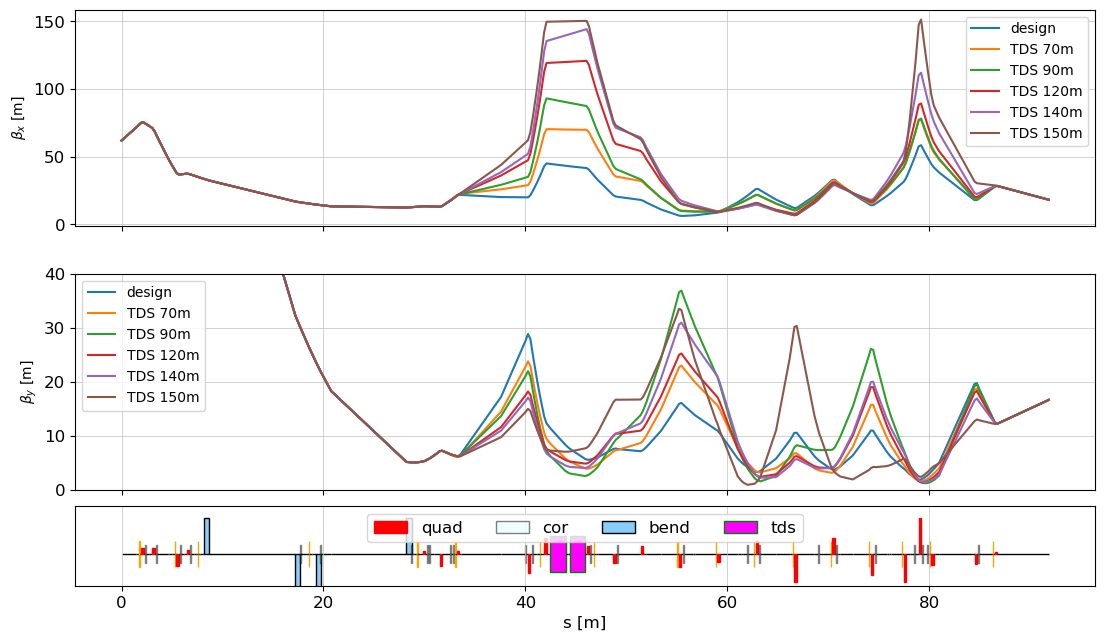

In [23]:
optics = list(quads_kicks_df.columns)

fig, (ax_extra, ax_xy) = plot_API(lat, figsize=(12,8), add_extra_subplot=True)
ax_extra.set_ylabel(r"$\beta_x$ [m]")
ax_xy.set_ylabel(r"$\beta_y$ [m]")
data = {}
for opt in optics:
    data[opt] = []
    for e in lat.sequence:
        if e.id in quads:
            e.k1 = quads_kicks_df[opt][e.id]

    tws = twiss(lat, tws0=tws_match_385)
    data[opt] = tws
    s = np.array([tw.s for tw in tws]) - tws[0].s
    bx = [tw.beta_x for tw in tws]
    by = [tw.beta_y for tw in tws]
    ax_extra.plot(s, bx, label=opt)
    ax_xy.plot(s, by, label=opt)
    ax_xy.set_ylim([0,40])
ax_xy.legend()
ax_extra.legend()
plt.show()